In [1]:
# Forces the notebook to always reload packages.
%reload_ext autoreload
%autoreload 2

# Single model experimentation

One of the critical points of feedback on our process is that we use multiple models.
We use these models to clearly distinguish between the types of variables we're testing: ecosystem contributions (in general, and in (non-)dependent projects) and collaboration metrics.

In part, this was done because variables correlated, thus affecting the model's quality.
This notebook explores how this correlation can be resolved.

Looking at the results of [the revised ecosystem model](./python_proj/modelling/notebooks/single_model_experimentation/ecosystem_model.ipynb), it shows that `ln(1 + WeightedEcosystemSecondOrderDegreeCentrality)` and `ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)` linearly correlate with a Spearman coefficient $\rho$ of $0.748$, which is substantial.

**Goal 1:** The problem that we try to solve in this notebook is to remove this correlation without losing insights.

**Goal 2:** A secondary objective here is to make the metric fully undirectional (w.r.t. directed vs. undirected graphs) as the original metric considered directed $\lambda$-edges and undirected $\mu$-edges.
This likely has no impact of the results as they in- and out-degree correlates strongly, however, optimally, both of these should be undirected.


## Normalized second-order degree centrality

**Basic definitions:**
- $x, y \in V$ vertices/nodes in the graph.
- $p, q \in P$ projects in the ecosystem.
- $\langle x, y, p \rangle_\lambda$ a $\lambda$-edge connecting nodes $x, y$ in project $p$.
- $E_\lambda(\cdot)$ a set of $\lambda$-edges with some number of constraints applied to them (e.g., who the edge connects to).

**Normalized ecosystem second-order multi-layer degree centrality (i.e., node centrality):**

We define node centrality of contributor $x$ in focal project $p$ as:
$$S(x, p) = \sum_{\lambda, \mu}^{L^2}w_\lambda w_\mu \cdot d(x,p,\lambda,\mu)$$
which multiplies the second-order degree centrality of a single pair of layers by multiplying them by their respective weights.

Here, weights are defined as:
$$w_\lambda = \frac{|E_\lambda|}{\sum_{\mu \not = \lambda}^L |E_\mu|}$$

The second-order degree centrality of a single pair of layers is defined as:
$$d(x, p, \lambda, \mu) = \frac{1}{|R_\lambda(x, p)|} \sum^{R_\lambda(x, p)}_{\langle x, y, q \rangle_\lambda} \big(|E_\mu(y)| - |E_\mu(y, x)|\big)$$
such that the first-order degree of all neighbors of $x$ are summed, minus the edges that connect $x$ and $y$.
This sum is then normalized by the number of ecosystem-spanning $\lambda$-edges that $x$ has (i.e., $|R_\lambda(x, p)|$); theoretically, this should remove correlation between the degree of $x$ and their second-order degree centrality.

The ecosystem-spannnig edges of $x$ are then defined as follows:
$$R_\lambda(x, p) = \big\{ \langle x, y, q \rangle_\lambda ~|~ p \not = q \land \langle x, y, q \rangle_\lambda \in E_\lambda(x) \big\}$$
Here, $p$ and $q$ are project identifiers and are used to exclusively include edges that are not part of the focal project; i.e., they are part of the ecosystem.


# Configuration

Defines some experimentation constants.

In [2]:
from pathlib import Path
from wmutils.file import safe_makedirs

thread_count = -1
window_size_in_days = 90

output_path = Path('./data/libraries/output/npm-libraries-1.6.0-2020-01-12/non_ftc_data.csv').absolute()
safe_makedirs(output_path.parent)
output_path = str(output_path)

chunk_base_path = str(Path('./data/tmp/data_chunks').absolute()) + "/"
chunk_output_base_path = str(
    Path("./data/tmp/sub_results").absolute()) + "/"

# Data sampling

We can't use pre-calculated data for this project as it lacks details to calculate $R_\lambda$.
Because the sliding window algorithm takes a long time to compute, we sample the last time window from the datasets.
The last time window should have a sufficient number of data points to do this analysis with.

In [3]:
from typing import Dict, Iterator
from datetime import datetime, timedelta
import json

import python_proj.utils.exp_utils as exp_utils
from python_proj.utils.exp_utils import iterate_through_multiple_chronological_issue_pr_datasets


exp_utils.load_paths_for_eco()

# Constants
issue_dataset = "issues_sorted_started_26_05_23_min_5_prs_no_invalid_no_dupes"
pr_dataset = "pulls_sorted_started_26_05_23_min_5_prs_no_invalid_no_dupes"

# Sample window start.
# Copied by running `tail -1` on the pr data file.
last_pr_date = '2020-01-11T23:44:58Z'
last_date = datetime.strptime(last_pr_date, exp_utils.DATETIME_FORMAT)
window_start = last_date - timedelta(days=window_size_in_days)


def create_file_for_final_window(output_path: Path, data_iter: Iterator[Dict]):
    """Creates a dataset for entries within the final time window."""
    with open(output_path, 'w+', encoding='utf-8') as output_file:
        KEY = 'closed_at'
        for entry in data_iter:
            # ensures we don't get a missing key exception
            if KEY not in entry:
                continue

            # ignores everything before the time window starts.
            closed_at = datetime.strptime(
                entry[KEY], exp_utils.DATETIME_FORMAT)
            if closed_at < window_start:
                continue

            jdata = json.dumps(entry)
            output_file.write(f'{jdata}\n')


In [4]:
# Creates data file for issues.
# creates output file for prs
input_issue_dataset_name = 'issues_last_window'
input_pr_dataset = 'prs_last_window'

issue_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=input_issue_dataset_name, data_type='issues')).absolute()
issues_iter = iterate_through_multiple_chronological_issue_pr_datasets([
                                                                       issue_dataset], [])


pr_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=input_pr_dataset, data_type='pull-requests')).absolute()
pr_iter = iterate_through_multiple_chronological_issue_pr_datasets([], [
                                                                   pr_dataset])

# This step can be skipped.
sample_last_month = False
if sample_last_month:
    create_file_for_final_window(issue_output_path, issues_iter)
    create_file_for_final_window(pr_output_path, pr_iter)

In [5]:
sampled_input_issue_dataset_name = 'issues_last_window_sampled'
sampled_input_pr_dataset = 'prs_last_window_sampled'

In [6]:
import random

# Do the same thin again, but now randomly sample the data.
t = 0.20


def random_sampler(output_path:  str, data_iter: Iterator[Dict]):
    sampled_count = 0
    with open(output_path, 'w+', encoding='utf-8') as output_file:
        for entry in data_iter:
            if random.random() > t:
                continue
            sampled_count += 1
            jdata = json.dumps(entry)
            output_file.write(f'{jdata}\n')
    print(f'Sampled {sampled_count} entries.')


sampled_issue_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=sampled_input_issue_dataset_name, data_type='issues')).absolute()
issues_iter = iterate_through_multiple_chronological_issue_pr_datasets([
    str(Path(issue_output_path).with_suffix("").name)], [])


sampled_pr_output_path = Path(exp_utils.CHRONOLOGICAL_DATASET_PATH(
    file_name=sampled_input_pr_dataset, data_type='pull-requests')).absolute()
pr_iter = iterate_through_multiple_chronological_issue_pr_datasets([], [
    str(Path(pr_output_path).with_suffix("").name)])


# This step can be skipped.
sample_random = False

if sample_random and sample_last_month:
    random_sampler(sampled_issue_output_path, issues_iter)
    random_sampler(sampled_pr_output_path, pr_iter)

In [7]:
input_issue_dataset_names = [sampled_input_issue_dataset_name]
input_pr_dataset_names = [sampled_input_pr_dataset]

# Implementation with sliding window algorithm

In [8]:
from python_proj.data_preprocessing.sliding_window_3 import create_sliding_window_dataset
from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.intra_eco_centrality import build_intra_eco_centrality_features
import python_proj.data_preprocessing.sliding_window_features as swf
from networkx import DiGraph
from typing import Tuple, Set, List, Iterable
from itertools import chain, product
from wmutils.collections.safe_dict import SafeDict

from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.intra_eco_centrality import _build_edge_key
from python_proj.data_preprocessing.sliding_window_features import (
    SlidingWindowFeature,
    Feature,
)
from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.centrality_features import SNAFeature
from python_proj.data_preprocessing.sliding_window_features.collaboration_experience.intra_eco_centrality import SNACentralityFeature
import python_proj.utils.exp_utils as exp_utils


class NormalizedSecondOrderEcosystemDegreeCentrality(SNACentralityFeature):
    """
    Note: this is not multi-layer degree centrality.
    That can only be calculated after the fact as it
    requires the total number of included edges for
    each layer. Instead, we return the individual
    values $d(x, p, \lambda, \mu)$.
    """

    def __init__(self, graph: DiGraph, edge_to_project_mapping: dict, edge_types: list[SNAFeature]) -> None:
        super().__init__(graph)
        self._edge_to_project_mapping: dict = edge_to_project_mapping
        self._edge_types = edge_types

    def add_entry(self, *args, **kwargs):
        # This class doesn't process any data entries itself, it relies on the entries of `self._edge_types`.
        return

    def remove_entry(self, *args, **kwargs):
        # This class doesn't process any data entries itself, it relies on the entries of `self._edge_types`.
        return

    def get_name(self) -> Iterator[str]:
        base_name = super().get_name()
        for la, mu in product(self._edge_types, self._edge_types):
            name = f'{base_name}({la.get_name()}.{mu.get_name()})'
            yield name

    def get_feature(self, entry: dict) -> list[int]:
        x = entry["user_data"]["id"]
        repo_path = entry[exp_utils.SOURCE_PATH_KEY]
        p = exp_utils.get_repository_name_from_source_path(repo_path)

        card_R_la, d_la_mu = self.calculate_d_la_mu(x, p)

        results = self.generate_output_vector(card_R_la, d_la_mu)
        return results

    def calculate_d_la_mu(self, x: int, p: str) -> Tuple[Dict[str, int], Dict[str, Dict[str, int]]]:
        card_R_la = SafeDict(default_value=0)
        d_la_mu = SafeDict(SafeDict, default_value_constructor_kwargs={
            'default_value': 0.0})

        # Collects the neighbors from incoming and outgoing edges; i.e., R.
        R = self.get_neighbors(x)
        for y in R:
            E_xy = self.get_edges_between(x, y)

            # Iterates through all edges that connect with the neighbor;
            # This is stil the outer loop.
            for la, T_xy in E_xy:
                for e_t in T_xy:
                    # Filters out edges in the same project.
                    q_key = _build_edge_key(y, x, e_t, la)
                    if q_key in self._edge_to_project_mapping:
                        q = self._edge_to_project_mapping[q_key]
                    else:
                        q_key_2 = _build_edge_key(x, y, e_t, la)
                        q = self._edge_to_project_mapping[q_key_2]
                    if p == q:
                        break

                    # Any element that reaches beyond this point is an element of R_\lambda(x, p).

                    # Updates the counter, used to normalize the entry ($1/|R_\lambda(x, p)|$).
                    card_R_la[la] += 1
                    nb_degree = self.calculate_nb_degree(x, y, e_t)
                    for mu, d in nb_degree.items():
                        d_la_mu[la][mu] += d

        return card_R_la, d_la_mu

    def calculate_nb_degree(self, x: int,  y: int, t: float) -> Dict[str, int]:
        """
        Calculates $e_\mu = (|E_\mu(y)| - |E_\mu(y, x)|)$ differentiating
        between each layer of the graph, for a single neighbor $y$.
        """

        e_mu = SafeDict(default_value=0)
        # Collects the neighbors from incoming and outgoing edges; i.e., R.
        # and removes all entries that are x.
        E = self.get_neighbors(y)
        E = (z for z in E if z != x)
        for z in E:
            E_yz = self.get_edges_between(y, z)
            # Per edge, it retrieves the timed edges, and iterates through those.
            for mu, T_yz in E_yz:
                for e_t in T_yz:
                    # Ignores non-chronological edges.
                    if e_t >= t:
                        continue
                    e_mu[mu] += 1
        return e_mu

    def get_neighbors(self, x: int) -> Set[int]:
        # Collects the neighbors from incoming and outgoing edges; i.e., R.
        # The first element of the in_edge_tuple is the neighbor.
        e_in = self._graph.in_edges(nbunch=[x])
        e_in = ((v, u) for u, v in e_in)
        # The second element of the out_edge tuple is the neighbor.
        e_out = self._graph.out_edges(nbunch=[x])
        nbs = {neighbor_id for _, neighbor_id in chain(e_in, e_out)}
        return nbs

    def get_edges_between(self, x: int, y: int) -> List[Dict]:
        def __helper_get_edges_between() -> Iterable[Tuple[str, Iterable[float]]]:
            """Helper method to iterate through all edges connnecting x and y."""
            E_in = self._graph.get_edge_data(x, y)
            if not E_in is None:
                yield from E_in.items()
            E_out = self._graph.get_edge_data(y, x)
            if not E_out is None:
                yield from E_out.items()

        def __helper_filter_duplicates(edges) -> Iterable[Tuple[str, Iterable[float]]]:
            # NOTE: The implementation of SNAFeature, which this class relies on does not consider duplicate edges.
            # However, these do affect the calculations, so need to be accounted for.
            # Characteristics of a duplicate edge are: same source and target node, same time stamp, same layer.
            # Within the context of this method, this comes down to testing their timestamps.
            for layer, edges in edges:
                exclusion_list = set()
                unique_edges = []
                for edge in edges:
                    if edge in exclusion_list:
                        continue
                    exclusion_list.add(edge)
                    unique_edges.append(edge)
                yield layer, unique_edges

        edges = __helper_get_edges_between()
        edges = __helper_filter_duplicates(edges)
        edges = list(edges)
        return edges

    def generate_output_vector(self, card_R_la: Dict[str, int], d_la_mu: Dict[str, Dict[str, int]]) -> Dict[str, Dict[str, float]]:
        # Normalizes the data and adds it to an output vector.
        out = []
        for la, mu in product(self._edge_types, self._edge_types):
            l = la.get_name()
            m = mu.get_name()
            norm_d_la_mu = d_la_mu[l][m] / (1 + card_R_la[l])
            out.append(norm_d_la_mu)
            if norm_d_la_mu > 0:
                pass
        return out

The following calculates $d(x, p, \lambda, \mu)$ for each tuple $\lambda, \mu$ and outputs those scores to the output file.
These sub-features need to be aggregated into $S(x, p)$ at a later stage in this pipeline.

This implements the feature factory for the sliding window.
It loads the features necessary to populate the multilayer graph, the feature implemented above, and general ecosystem contribution features.
This last one is added so we can test correlation later on.

In [9]:
def feature_factory() -> Tuple[list[SlidingWindowFeature], list[SlidingWindowFeature], list[Feature]]:
    pr_graph_features, issue_graph_features, _ = build_intra_eco_centrality_features()
    graph = pr_graph_features[0]._graph
    edge_to_project_mapping = pr_graph_features[0]._edge_to_project_mapping

    edge_types = list(chain(pr_graph_features, issue_graph_features))

    pr_graph_features.append(
        NormalizedSecondOrderEcosystemDegreeCentrality(graph, edge_to_project_mapping, edge_types))

    other_pr = swf.build_other_features()
    control_sw, control = swf.build_control_variables()
    ip_issue, ip_pr = swf.build_intra_project_features()
    eco_se_pr, eco_se_issue = swf.build_eco_se_features()
    eco_pr, eco_issue = swf.build_eco_experience()
    deco_pr, deco_issue, ideco_pr, ideco_issue = swf.build_deco_features()

    issue_sw_features = [
        *ip_issue,
        *eco_se_issue,
        *eco_issue,
        *deco_issue,
        *ideco_issue,
        *issue_graph_features,
    ]

    pr_sw_features = [
        *control_sw,
        *ip_pr,
        *eco_se_pr,
        *eco_pr,
        *deco_pr,
        *ideco_pr,
        *pr_graph_features,
    ]

    pr_features = [
        *other_pr,
        *control,
    ]

    # Returns a triple: issue_sw_features, pr_sw_features, pr_features
    return issue_sw_features, pr_sw_features, pr_features

This generates the to-be-evaluated dataset dataset.

In [10]:
analyze_all_data = False

if analyze_all_data:
    print("Running with whole dataset.")
    input_issue_dataset_names = [issue_dataset]
    input_pr_dataset_names = [pr_dataset]
    thread_count = 12

In [11]:
# # This is a debug option. This should be false.
# only_aggregate = True

# if only_aggregate:
#     from python_proj.data_preprocessing.sliding_window_3 import __merge_chunk_results, __get_output_features

#     chunk_file_names = [chunk_output_base_path +
#                         f"{chunk_no}" for chunk_no in range(1, 44)]
#     chunk_names = list(chunk_file_names)
#     print(chunk_file_names)

#     issue_sw_features, pr_sw_features, pr_features = feature_factory()
#     output_features, all_features = __get_output_features(
#         pr_features, pr_sw_features, issue_sw_features
#     )
#     output_features: Iterable[Feature] = output_features

#     output_features = [
#         feat for feat in output_features if feat.is_output_feature()]

#     __merge_chunk_results(output_path, chunk_file_names,
#                           chunk_output_base_path, output_features, delete_chunk=False)

In [12]:
run_df_generation_algo = False

if run_df_generation_algo:
    create_sliding_window_dataset(output_path, chunk_base_path, chunk_output_base_path,
                                  input_issue_dataset_names, input_pr_dataset_names,
                                  feature_factory, window_size_in_days,
                                  thread_count)

# Analysis setup

Loads the generated data file and tests for correlation.

In [13]:
import pandas as pd

input_path = r'/workspaces/msc_thesis/python_proj/modelling/notebooks/single_model_experimentation/data/libraries/npm-libraries-1.6.0-2020-01-12/output/non_ftc_data.csv'

df: pd.DataFrame = pd.read_csv(input_path, header=0)

df.describe()

,ID,Submitter ID,PR Number,ControlPullRequestLifeTimeInMinutes,ControlNumberOfCommitsInPullRequest,ControlIntraProjectPullRequestExperienceOfIntegrator,IntraProjectSubmitterPullRequestSubmissionCount,IntraProjectSubmitterPullRequestSuccessRate,IntraProjectSubmitterPullRequestCommentCount,EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator,...,EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter,EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter,EcosystemExperienceSubmitterIssueSubmissionCount,EcosystemExperienceSubmitterIssueCommentCount,DependencyEcosystemExperienceSubmitterIssueSubmissionCount,DependencyEcosystemExperienceSubmitterIssueCommentCount,NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount,NonDependencyEcosystemExperienceSubmitterIssueCommentCount,InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount,InversedDependencyEcosystemExperienceSubmitterIssueCommentCount
count,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,...,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06
mean,1.437031e+08,5.115920e+06,3.742826e+03,3.134884e+04,4.946474e+00,1.912286e+02,1.675834e+01,5.332312e-01,2.177316e+01,6.109087e-01,...,8.664509e-02,1.490733e+00,2.631451e+00,1.796389e+01,1.749964e-01,8.709742e-01,2.289594e+00,1.580416e+01,1.850179e-01,1.351867e+00
std,9.743408e+07,7.960629e+06,7.925014e+03,1.358488e+05,7.291565e+01,4.759020e+02,5.587018e+01,4.624880e-01,6.603859e+01,8.752814e+00,...,1.282110e+00,2.398954e+01,7.997211e+00,6.724727e+01,1.557984e+00,1.195306e+01,7.076691e+00,6.152523e+01,2.425496e+00,1.665047e+01
min,6.870000e+02,1.000000e+00,1.000000e+00,1.666667e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.685160e+07,4.574810e+05,9.800000e+01,5.286667e+01,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.342629e+08,1.593054e+06,5.380000e+02,9.765500e+02,1.000000e+00,3.000000e+01,2.000000e+00,8.000000e-01,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.225189e+08,6.295984e+06,2.773000e+03,7.305562e+03,3.000000e+00,1.400000e+02,1.600000e+01,1.000000e+00,1.500000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
max,3.473070e+08,5.830055e+07,8.297600e+04,4.489490e+06,1.000000e+04,4.281000e+03,1.703000e+03,1.000000e+00,2.038000e+03,5.540000e+02,...,2.190000e+02,5.687000e+03,2.332000e+03,7.630000e+03,3.690000e+02,9.270000e+02,2.332000e+03,7.630000e+03,7.410000e+02,2.764000e+03


In [14]:
print(len(df.columns))
print(df.columns)

72
Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged', 'SubmitterIsFirstTimeContributor',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'IntraProjectSubmitterPullRequestSubmissionCount',
       'IntraProjectSubmitterPullRequestSuccessRate',
       'IntraProjectSubmitterPullRequestCommentCount',
       'EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator',
       'EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter',
       'EcosystemShared

In [15]:
# Manual check of a data point to see if it makes sense.
print(df.iloc[1, :])

ID                                                                                        89750
Project Name                                                          mediaelement/mediaelement
Submitter ID                                                                             107073
PR Number                                                                                   153
Closed At                                                                  2011-03-17T14:02:35Z
                                                                                ...            
DependencyEcosystemExperienceSubmitterIssueCommentCount                                       0
NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount                                 0
NonDependencyEcosystemExperienceSubmitterIssueCommentCount                                    0
InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount                            0
InversedDependencyEcosystemExperienceSub

In [16]:
def split_meta_non_meta_columns(df: pd.DataFrame):
    predictor_features = df.columns[6:]
    df_meta = df.drop(predictor_features, axis=1)
    df = df[predictor_features]
    return df_meta, df

df_meta, df = split_meta_non_meta_columns(df)
df.describe()

,ControlPullRequestLifeTimeInMinutes,ControlNumberOfCommitsInPullRequest,ControlIntraProjectPullRequestExperienceOfIntegrator,IntraProjectSubmitterPullRequestSubmissionCount,IntraProjectSubmitterPullRequestSuccessRate,IntraProjectSubmitterPullRequestCommentCount,EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator,EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter,EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator,EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter,...,EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter,EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter,EcosystemExperienceSubmitterIssueSubmissionCount,EcosystemExperienceSubmitterIssueCommentCount,DependencyEcosystemExperienceSubmitterIssueSubmissionCount,DependencyEcosystemExperienceSubmitterIssueCommentCount,NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount,NonDependencyEcosystemExperienceSubmitterIssueCommentCount,InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount,InversedDependencyEcosystemExperienceSubmitterIssueCommentCount
count,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,...,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06
mean,3.134884e+04,4.946474e+00,1.912286e+02,1.675834e+01,5.332312e-01,2.177316e+01,6.109087e-01,1.467327e-01,3.263646e-01,1.389939e-01,...,8.664509e-02,1.490733e+00,2.631451e+00,1.796389e+01,1.749964e-01,8.709742e-01,2.289594e+00,1.580416e+01,1.850179e-01,1.351867e+00
std,1.358488e+05,7.291565e+01,4.759020e+02,5.587018e+01,4.624880e-01,6.603859e+01,8.752814e+00,3.463220e+00,2.943403e+00,1.703085e+00,...,1.282110e+00,2.398954e+01,7.997211e+00,6.724727e+01,1.557984e+00,1.195306e+01,7.076691e+00,6.152523e+01,2.425496e+00,1.665047e+01
min,1.666667e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.286667e+01,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.765500e+02,1.000000e+00,3.000000e+01,2.000000e+00,8.000000e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,7.305562e+03,3.000000e+00,1.400000e+02,1.600000e+01,1.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,2.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00
max,4.489490e+06,1.000000e+04,4.281000e+03,1.703000e+03,1.000000e+00,2.038000e+03,5.540000e+02,5.400000e+02,2.490000e+02,1.450000e+02,...,2.190000e+02,5.687000e+03,2.332000e+03,7.630000e+03,3.690000e+02,9.270000e+02,2.332000e+03,7.630000e+03,7.410000e+02,2.764000e+03


# Feature aggregation

Aggregates the 25 sub-metrics $d(x, p, \lambda, \mu)$ into $S(x, p)$.

In [17]:
import json 

# This is copied from one of the output cells.
edge_counts = {
    "PRIntegratorToSubmitterV2": 1043559,
    "PRCommenterToSubmitterV2": 2808889,
    "PRCommenterToCommenterV2": 24595282,
    "IssueCommenterToCommenterV2": 73500466,
    "IssueCommenterToSubmitterV2": 5806894,
}
total_edges = sum(edge_counts.values())


def calculate_weight(value):
    """Calculates normalized complement of the weight."""
    percentage_complement = 1 - (value / (total_edges))
    normalized_perc_compl = percentage_complement / (len(edge_counts) - 1)
    return normalized_perc_compl


edge_weights = {key: calculate_weight(value)
                for key, value in edge_counts.items()}
total_weight = sum(edge_weights.values())
edge_weights = {key: value / total_weight for key,
                value in edge_weights.items()}

print("Edge weights =", json.dumps(edge_weights, indent=4))

Edge weights = {
    "PRIntegratorToSubmitterV2": 0.24757886379195637,
    "PRCommenterToSubmitterV2": 0.24348316399717174,
    "PRCommenterToCommenterV2": 0.19293707610471117,
    "IssueCommenterToCommenterV2": 0.07947333160781547,
    "IssueCommenterToSubmitterV2": 0.23652756449834528
}


### Node centrality aggregation

In [18]:
from itertools import product

scopes = ["Ecosystem", "IntraProject"]
edge_types = edge_weights.keys()
directions = ["In", "Out"]
combinations = product(edge_types, edge_types)

BASE_EDGE_FIELD = "NormalizedSecondOrderEcosystemDegreeCentrality({connecting_edge}.{experience_edge})"
TARGET_FIELD = "NormalizedSecondOrderEcosystemDegreeCentrality"

centrality_features = []

# Iterates through all edge variables.
for connecting_edge, experience_edge in combinations:
    edge_field = BASE_EDGE_FIELD.format(
        connecting_edge=connecting_edge,
        experience_edge=experience_edge,
    )

    # Applies the weights to edge.
    connecting_weight = edge_weights[connecting_edge]
    experience_weight = edge_weights[experience_edge]
    total_weight = connecting_weight * experience_weight

    df[edge_field] = df[edge_field].multiply(total_weight)

    # Add contribution to centrality.
    # target_field = BASE_TARGET_FIELD.format(scope=scope, direction=direction)
    # Sets initial value if it doesn't exist yet.
    if TARGET_FIELD not in df.columns:
        df[TARGET_FIELD] = 0
        centrality_features.append(TARGET_FIELD)

    df[TARGET_FIELD] = df[TARGET_FIELD].add(df[edge_field])

    # Drops the edge column, as it's only necessary once.
    df = df.drop(edge_field, axis=1)

print(f"{len(df.columns)=}")
df[centrality_features].describe()

len(df.columns)=42


,NormalizedSecondOrderEcosystemDegreeCentrality
count,1.781682e+06
mean,3.079163e+01
std,7.210805e+01
min,0.000000e+00
25%,0.000000e+00
50%,2.138503e+00
75%,2.688002e+01
max,1.437791e+03


### Link intensity aggregation

In [19]:
se_features = {
    "PRIntegratorToSubmitterV2": [
        'EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
        'EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
    ],
    "PRCommenterToSubmitterV2": [
        'EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator',
        'EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter',
    ],
    "PRCommenterToCommenterV2": [
        'EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter'
    ],
    "IssueCommenterToSubmitterV2": [
        'EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator',
        'EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter',
    ],
    "IssueCommenterToCommenterV2": [
        'EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter',
    ],
}

link_intensity = 'LinkIntensity'

df[link_intensity] = 0

for weight_key, features in se_features.items():
    weight = edge_weights[weight_key]

    for field in features:
        df[link_intensity] = df[link_intensity].add(df[field].multiply(weight))

df[[link_intensity]].describe()

,LinkIntensity
count,1.781682e+06
mean,7.952037e-01
std,7.289647e+00
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,7.680281e+02


In [20]:
from wmutils.collections.list_access import flatten

dropped = list(flatten(se_features.values()))
print(dropped)
print(len(dropped))

df = df.drop(dropped, axis=1)

['EcosystemSharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator', 'EcosystemSharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter', 'EcosystemSharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator', 'EcosystemSharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter', 'EcosystemSharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter', 'EcosystemSharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator', 'EcosystemSharedExperienceIssueSubmittedByIntegratorCommentedOnBySubmitter', 'EcosystemSharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter']
8


# Newcomer re-identification

We implemented the parallelized dataset generation algorithm. This one cannot calculate the `SubmitterIsFirstTimeContributor` feature correctly. This is adjusted here.

In [21]:
non_ftcs = set()

ftc_key = 'SubmitterIsFirstTimeContributor'
new_ftc_key = 'NewSubmitterIsFirstTimeContributor'

sub_id_key = 'Submitter ID'
proj_key = 'Project Name'

df[new_ftc_key] = False

for (i, row) in df_meta.iterrows():
    sub_id = row[sub_id_key]
    proj_id = row[proj_key]
    entry = f'{proj_id}{sub_id}'

    is_ftc = not entry in non_ftcs
    df.loc[i, new_ftc_key] = is_ftc

    non_ftcs.add(entry)

In [22]:
# Impact analysis.

print("Old", df[[ftc_key]].value_counts())
print("\nNew", df[[new_ftc_key]].value_counts())

delta = df[[new_ftc_key]].value_counts() - df[[ftc_key]].value_counts()
print("\nDelta", delta)

Old SubmitterIsFirstTimeContributor
False                              1044833
True                                736849
Name: count, dtype: int64

New NewSubmitterIsFirstTimeContributor
False                                 1253406
True                                   528276
Name: count, dtype: int64

Delta NewSubmitterIsFirstTimeContributor
False                                 208573
True                                 -208573
Name: count, dtype: int64


In [23]:
df[ftc_key] = df[new_ftc_key]
df = df.drop(new_ftc_key, axis=1)

# Transforming and scaling

Applies add-one log transform to the data, removes outliers using cook's distance, and then applies min-max scaling to the leftover data.

In [24]:
# applies add-one log transform

import numpy as np

ln_key = "ln(1 + {field})"

df: pd.DataFrame = df

num_fields = df.select_dtypes(include='number').columns
num_fields = [field for field in num_fields if 'SuccessRate' not in field]

for column in num_fields:
    new_field = ln_key.format(field=column)
    df[new_field] = df[column].add(1).apply(np.log)

df = df.drop(num_fields, axis=1)

In [25]:
# applies min-max scale

def scale(_df: pd.DataFrame, scaled_fields: pd.Series):
    scaled_df = _df.copy()

    for feature in scaled_fields:
        feature_min = scaled_df[feature].min()
        feature_max = scaled_df[feature].max()
        feature_delta = feature_max - feature_min

        scaled_df[feature] = (
            scaled_df[feature].subtract(feature_min).divide(feature_delta)
        )

    return scaled_df

num_fields = df[df.columns[5:]].select_dtypes(include='number').columns
df = scale(df, num_fields)


In [26]:
df.describe()

,IntraProjectSubmitterPullRequestSuccessRate,EcosystemExperienceSubmitterPullRequestSuccessRate,DependencyEcosystemExperienceSubmitterPullRequestSuccessRate,NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator),ln(1 + IntraProjectSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterPullRequestCommentCount),...,ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + EcosystemExperienceSubmitterIssueCommentCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality),ln(1 + LinkIntensity)
count,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,...,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06,1.781682e+06
mean,5.332312e-01,3.702273e-01,8.253580e-02,3.480522e-01,4.127385e-02,4.250218e-01,1.185376e-01,4.110846e-01,2.110097e-01,1.919568e-01,...,8.022792e-02,1.335643e-01,9.954901e-03,1.729960e-02,7.432063e-02,1.253979e-01,6.822668e-03,1.255973e-02,2.391324e-01,1.849075e-02
std,4.624880e-01,4.470434e-01,2.685106e-01,4.420539e-01,1.925861e-01,2.148119e-01,7.358596e-02,2.422358e-01,2.077463e-01,2.219193e-01,...,1.201844e-01,1.762489e-01,5.039711e-02,7.585979e-02,1.145803e-01,1.704874e-01,4.487173e-02,7.072848e-02,2.560497e-01,7.880974e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.594638e-01,7.525668e-02,2.142695e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.489017e-01,7.525668e-02,4.106572e-01,1.476484e-01,9.096163e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.572903e-01,0.000000e+00
75%,1.000000e+00,9.178082e-01,0.000000e+00,9.000000e-01,0.000000e+00,5.803648e-01,1.505134e-01,5.918029e-01,3.807707e-01,3.638465e-01,...,1.416667e-01,2.326004e-01,0.000000e+00,0.000000e+00,1.416667e-01,2.176640e-01,0.000000e+00,0.000000e+00,4.576612e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# Correlation testing

Uses VIF and Spearman correlation to identify problematically multicollinear features.

## Variance inflation factor (VIF)

Calculates variance inflation factor to identify problematic multicollinearity.

In [27]:
# Replaces binary values with numeric variants so VIF can be calculated.

from statsmodels.stats.outliers_influence import variance_inflation_factor

value_mapper = {False: 0, True: 1}

binary_fields = df.select_dtypes(exclude="number")
print(f"{len(binary_fields.columns)=}")
for feature in binary_fields:
    df[feature] = df[feature].replace(value_mapper)

len(binary_fields.columns)=5


In [28]:
# Calculates VIF

calculate_vif = False

if calculate_vif:
    vif_df = pd.DataFrame()
    vif_df["variable"] = df.columns
    vif_df["VIF"] = [
        variance_inflation_factor(df.values, i) for i in range(df.shape[1])
    ]

    print(vif_df)

In [29]:
# Identifies problematic fields, according to VIF.
if calculate_vif:
    VIF_THRESHOLD = 5

    problematic_vif = vif_df[vif_df["VIF"] >= VIF_THRESHOLD]

    print(f"{VIF_THRESHOLD}")
    print(f"Problematic VIF fields: {len(problematic_vif)}.")
    print("Problematic VIF scores:\n", problematic_vif)

## Spearman correlation

Calculates pairwise spearman correlation between variables to make it easier to identify what variables are multicollinear.

In [30]:
# Calculates Spearman correlation between variables.

import json


def get_spearman_correlation(df: pd.DataFrame, coof_threshold: float):
    corr = df.corr(method="spearman")
    print(f"{coof_threshold=}")
    correlating_fields = []
    for rowIndex, row in corr.iterrows():
        for columnIndex, coof in row.items():
            if columnIndex <= rowIndex:
                continue
            if abs(coof) < coof_threshold:
                continue
            correlating_fields.append([columnIndex, rowIndex, coof])
    correlating_fields = [list(entry) for entry in correlating_fields]
    return corr, correlating_fields


corr, correlating_fields = get_spearman_correlation(df, coof_threshold=0.5)
print("Correlating pairs:\n", json.dumps(correlating_fields, indent=2))

coof_threshold=0.5
Correlating pairs:
 [
  [
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "SubmitterIsFirstTimeContributor",
    -0.7429206366638693
  ],
  [
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "SubmitterIsFirstTimeContributor",
    -0.6180041359139887
  ],
  [
    "ControlPullRequestHasComments",
    "ControlPullRequestHasCommentByExternalUser",
    0.5119821295214062
  ],
  [
    "SubmitterIsFirstTimeContributor",
    "IntraProjectSubmitterPullRequestSuccessRate",
    -0.6956727144529419
  ],
  [
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",
    "IntraProjectSubmitterPullRequestSuccessRate",
    0.6506384359491295
  ],
  [
    "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    0.9430839792444902
  ],
  [
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    0.83584

In [31]:
# Generates transitive closure of correlating fields;
# i.e., it identifies clusters of correlating features.

from typing import List, Set


transitive_closures: List[Set[str]] = []
# Iterates through all correlating fields.
for field_a, field_b, _ in correlating_fields:
    was_added = False
    # Sees if one of the components is part of a transitive closure.
    for transitive_closure in transitive_closures:
        if field_a in transitive_closure or field_b in transitive_closure:
            was_added = True
            transitive_closure.update((field_a, field_b))
    # Adds new closure if they are not.
    if not was_added:
        new_set = set()
        new_set.update((field_a, field_b))
        transitive_closures.append(new_set)

# Prepares the closures to be printed.
transitive_closures = [sorted(list(closure))
                       for closure in transitive_closures]
print(
    "Transitive closure of correlating pairs:\n",
    json.dumps(transitive_closures, indent=2),
)

Transitive closure of correlating pairs:
 [
  [
    "IntraProjectSubmitterPullRequestSuccessRate",
    "SubmitterIsFirstTimeContributor",
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
    "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)"
  ],
  [
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments"
  ],
  [
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentC

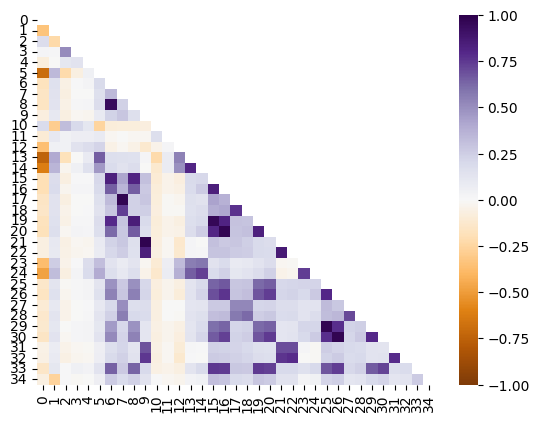

In [32]:
# Plots correlation as seaborn plot.

import seaborn as sb

tick_labels = list(range(len(df.columns)))
rows, cols = corr.shape
mask = np.invert(np.tril(np.ones((rows, cols), dtype=bool), k=-1))
dataplot = sb.heatmap(
    corr,
    cmap="PuOr",
    xticklabels=tick_labels,
    yticklabels=tick_labels,
    mask=mask,
    vmin=-1,
    vmax=1,
)

[[0, "SubmitterIsFirstTimeContributor"], [1, "ControlIntegratedBySameUser"], [2, "ControlPullRequestHasComments"], [3, "ControlPullRequestHasCommentByExternalUser"], [4, "ControlHasHashTagInDescription"], [5, "IntraProjectSubmitterPullRequestSuccessRate"], [6, "EcosystemExperienceSubmitterPullRequestSuccessRate"], [7, "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate"], [8, "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate"], [9, "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate"], [10, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [11, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [12, "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)"], [13, "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)"], [14, "ln(1 + IntraProjectSubmitterPullRequestCommentCount)"], [15, "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)"], [16, "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)"], [17, "ln(1 + Dependenc

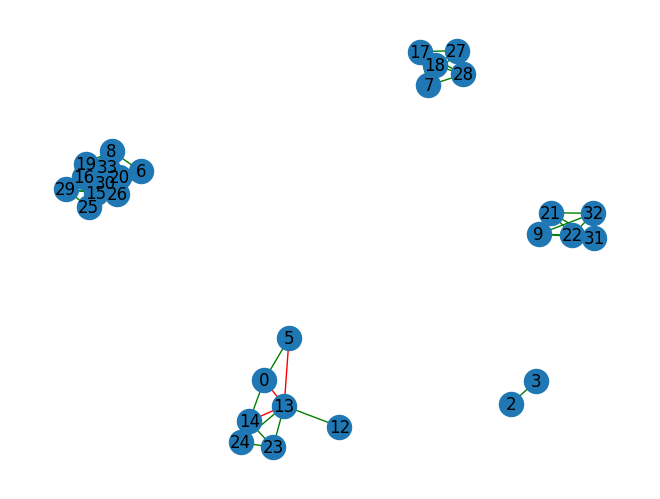

In [33]:
# Plots correlations as a graph.

import networkx as nx


def visualize_correlating_features(correlating_fields, df: pd.DataFrame):
    fields = list(df.columns)
    enumerated_list = list(enumerate(fields))
    ids = []
    edge_colors = []
    for source, target, coof in correlating_fields:
        source_idx = fields.index(source)
        target_idx = fields.index(target)
        ids.append((source_idx, target_idx))
        edge_colors.append("red" if coof < 0 else "green")

    # Create an empty graph
    graph = nx.Graph()

    # Add edges to the graph from the list of tuples
    graph.add_edges_from(ids)

    pos = nx.spring_layout(graph, k=0.4)
    nx.draw(graph, pos, with_labels=True, edge_color=edge_colors)

    if len(correlating_fields) == 0:
        print("When there are no correlating fields, the figure is supposed to be empty.")

    print(json.dumps(enumerated_list))


visualize_correlating_features(correlating_fields, df)

# Data cleaning

## Resolving skewed dataset

Applies a limit on the number of pull requests a single project can have in our analysis. This helps resolving the significant skew in distribution.

In [34]:
import math

all_df = pd.concat([df_meta, df], axis=1)

# all data plot
pr_count_per_project = all_df['Project Name'].groupby(
    all_df["Project Name"]).count()
pr_count_per_project = pr_count_per_project.sort_values()

# up to 97th Percentile plot
project_count = len(pr_count_per_project)
# NOTE: with the 74th percentile the PR counts of the capped
# elite and the rest are approximately equal. The total number
# of entries is then 479.801.
percentile = 98
print(f"{percentile=}")
percentile_index = math.floor(project_count * percentile / 100)
print(f"{percentile_index=}")
print(f"Top project count: {project_count - percentile_index}")
perc_data = pr_count_per_project.iloc[:percentile_index]

# Printing some stats.
total_pull_count = sum(pr_count_per_project.values)
bottom_pull_count = sum(perc_data.values)
ratio = 100 * bottom_pull_count / total_pull_count
print(
    f"Pull Requests below {percentile}th percentile: {bottom_pull_count}/{total_pull_count} ({ratio:.03f}%)\n"
)

percentile=98
percentile_index=19623
Top project count: 401
Pull Requests below 98th percentile: 922419/1781682 (51.772%)



In [35]:
# Calculates cap

maximum_pulls = max(perc_data.values)
capped_top_pulls_count = maximum_pulls * (project_count - percentile_index)

print(f"{maximum_pulls=}")
print(f"{capped_top_pulls_count=}")
print(f"{bottom_pull_count + capped_top_pulls_count=}")

maximum_pulls=668
capped_top_pulls_count=267868
bottom_pull_count + capped_top_pulls_count=1190287


In [36]:
from wmutils.general import Counter

sampling_seed_counter = Counter()


def sample_with_maximum(project_subset: pd.DataFrame, max_sample_size: int):
    """Randomly samples the group if its number of elements exceed the provided cap."""
    if len(project_subset) > max_sample_size:
        seed = sampling_seed_counter.get_next()
        return project_subset.sample(max_sample_size, random_state=seed)
    return project_subset


# Samples top projects with the PR cap.
sampled_df = all_df.groupby("Project Name").apply(
    sample_with_maximum, max_sample_size=maximum_pulls
)

print(f"Sub-sampled df length: {len(sampled_df)}")

df_meta, df = split_meta_non_meta_columns(sampled_df)

Sub-sampled df length: 1190287


## Removing multicollinear variables

In [37]:
dropped_fields = [
    # (Cluster 0) Upstream dependency data. (9, 21, 22, 31, 32)
    "InversedDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + InversedDependencyEcosystemExperienceSubmitterIssueCommentCount)",
    # "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",

    # (Cluster 1) Downstream dependency data. (7, 17, 18, 27, 28)
    "DependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + DependencyEcosystemExperienceSubmitterIssueCommentCount)",
    # "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",

    # (Cluster 2) Intra project experience. (0, 5, 13, 14, 23, 24)
    "ln(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)",
    # "SubmitterIsFirstTimeContributor",
    "IntraProjectSubmitterPullRequestSuccessRate",
    "ln(1 + IntraProjectSubmitterIssueCommentCount)",
    # "ln(1 + IntraProjectSubmitterIssueSubmissionCount)",
    "ln(1 + IntraProjectSubmitterPullRequestCommentCount)",
    "ln(1 + IntraProjectSubmitterPullRequestSubmissionCount)",

    # (Cluster 3) Ecosystem experience (6,8,15,16,19,20,25,26,29,30,33)
    "EcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + EcosystemExperienceSubmitterIssueCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestCommentCount)",
    "ln(1 + EcosystemExperienceSubmitterPullRequestSubmissionCount)",

    "NonDependencyEcosystemExperienceSubmitterPullRequestSuccessRate",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueCommentCount)",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterIssueSubmissionCount)",
    "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestCommentCount)",
    # "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)",

    # "ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)",
]

In [38]:
f_df = df.drop(dropped_fields, axis=1)

print(len(f_df.columns))
print(f_df.columns)

13
Index(['SubmitterIsFirstTimeContributor', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)',
       'ln(1 + LinkIntensity)'],
      dtype='object')


### Re-run pairwise Spearman correlation

This is to visualize the leftover issues in the dataset, which helps when defining the feature exclusion list.

coof_threshold=0.5
[[0, "SubmitterIsFirstTimeContributor"], [1, "ControlIntegratedBySameUser"], [2, "ControlPullRequestHasComments"], [3, "ControlPullRequestHasCommentByExternalUser"], [4, "ControlHasHashTagInDescription"], [5, "ln(1 + ControlPullRequestLifeTimeInMinutes)"], [6, "ln(1 + ControlNumberOfCommitsInPullRequest)"], [7, "ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [8, "ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [9, "ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)"], [10, "ln(1 + IntraProjectSubmitterIssueSubmissionCount)"], [11, "ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)"], [12, "ln(1 + LinkIntensity)"]]


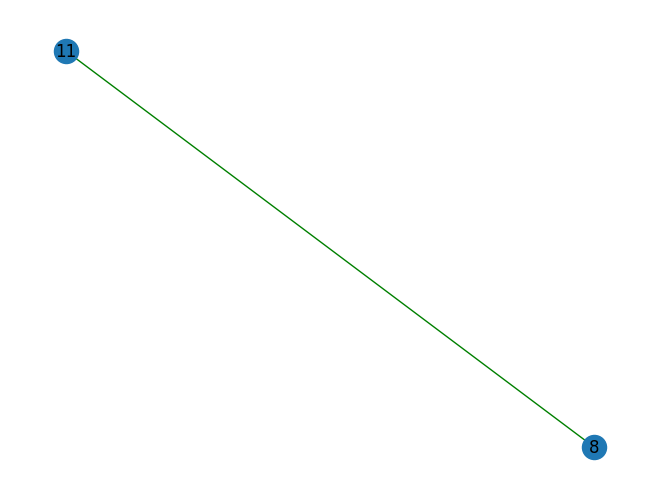

In [39]:
_, f_correlating_fields = get_spearman_correlation(f_df, coof_threshold=0.5)
visualize_correlating_features(f_correlating_fields, f_df)

## Removing outliers

Removes outliers using cook's distance $k = 4 / len(df)$, and re-scales the data.

In [40]:
# Replaces binary values with numeric variants so VIF can be calculated.

value_mapper = {False: 0, True: 1}

binary_fields = f_df.select_dtypes(exclude="number")
print(f"{len(binary_fields.columns)=}")
for feature in binary_fields:
    f_df[feature] = f_df[feature].replace(value_mapper)

len(binary_fields.columns)=0


In [41]:
import statsmodels.api as sm
import scipy

pr_merged_key = 'PullRequestIsMerged'

X_constant = sm.add_constant(f_df)

# Use GLM method for logreg here so that we can retrieve the influence measures
logit_results = sm.GLM(
    df_meta[pr_merged_key], X_constant, family=sm.families.Binomial()
).fit()

# Get influence measures
influence = logit_results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook's distance values only
diagnosis_df = summ_df[["cooks_d"]]

# Set Cook's distance threshold
cook_threshold = 4 / len(f_df)

# Append absolute standardized residual values
diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))

# Find observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[
    (diagnosis_df["cooks_d"] > cook_threshold) & (diagnosis_df["std_resid"] > 3)
]


# Show top 5 highly influential outlier observations
extreme.sort_values("cooks_d", ascending=False).head(10)

/tmp/ipykernel_29140/3862443814.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = scipy.stats.zscore(logit_results.resid_pearson)
/tmp/ipykernel_29140/3862443814.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diagnosis_df["std_resid"] = diagnosis_df["std_resid"].apply(lambda x: np.abs(x))


cooks_d  std_resid
Project Name                                                        
babel/ember-cli-babel                   265987   0.000147   7.195253
arlac77/repository-provider             1315934  0.000108  12.883105
sindresorhus/meow                       415369   0.000108   4.447117
arlac77/npm-template-sync               1282693  0.000107  29.132455
arlac77/repository-provider             1577308  0.000107  14.659143
google/gts                              1467491  0.000106   5.973732
arlac77/repository-provider             1472594  0.000106  16.239836
                                        1629084  0.000106  13.385298
arlac77/npm-template-sync               1241642  0.000105  26.991431
arlac77/aggregation-repository-provider 1523913  0.000105  32.808472

In [42]:
logit_df = f_df.drop(extreme.index)
tested_dependents = df_meta.drop(extreme.index)

f_df.describe()

,SubmitterIsFirstTimeContributor,ControlIntegratedBySameUser,ControlPullRequestHasComments,ControlPullRequestHasCommentByExternalUser,ControlHasHashTagInDescription,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality),ln(1 + LinkIntensity)
count,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06
mean,3.535013e-01,4.249404e-01,6.247334e-01,2.934511e-01,3.272614e-01,4.195441e-01,1.183103e-01,3.211054e-02,1.433330e-01,2.304283e-02,7.289240e-02,2.545725e-01,2.193965e-02
std,4.780568e-01,4.943342e-01,4.841919e-01,4.553435e-01,4.692138e-01,2.255599e-01,7.146241e-02,1.083919e-01,1.986850e-01,9.834676e-02,1.332759e-01,2.596477e-01,8.752922e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.368024e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.433422e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.982336e-01,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.859488e-01,1.505134e-01,0.000000e+00,2.325884e-01,0.000000e+00,1.089927e-01,4.753101e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [43]:
f_df = scale(f_df, f_df.columns)
f_df.describe()

,SubmitterIsFirstTimeContributor,ControlIntegratedBySameUser,ControlPullRequestHasComments,ControlPullRequestHasCommentByExternalUser,ControlHasHashTagInDescription,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality),ln(1 + LinkIntensity)
count,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06
mean,3.535013e-01,4.249404e-01,6.247334e-01,2.934511e-01,3.272614e-01,4.195441e-01,1.183103e-01,3.211054e-02,1.433330e-01,2.304283e-02,7.289240e-02,2.545725e-01,2.193965e-02
std,4.780568e-01,4.943342e-01,4.841919e-01,4.553435e-01,4.692138e-01,2.255599e-01,7.146241e-02,1.083919e-01,1.986850e-01,9.834676e-02,1.332759e-01,2.596477e-01,8.752922e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.368024e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.433422e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.982336e-01,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.859488e-01,1.505134e-01,0.000000e+00,2.325884e-01,0.000000e+00,1.089927e-01,4.753101e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [44]:
len(f_df)

1190287

# Modeling

## Safe/load data

Stores the dataset generated in the previous steps if there is one.
Loads a dataset if one isn't stored in memory already.

In [45]:
from pathlib import Path

output_path = Path('./data/libraries/npm-libraries-1.6.0-2020-01-12/output/preprocessed_data.csv').absolute()

try:
    all_df = pd.concat([df_meta, f_df], axis=1)
    all_df.to_csv(output_path, index=False)
except NameError:
    # only runs the above if all used variables are defined.
    pass

In [46]:
import pandas as pd

try:
    f_df
    # Loads f_df if it is undefined.
except NameError:
    all_df = pd.read_csv(output_path, header=0)
    df_meta, f_df = split_meta_non_meta_columns(all_df)

f_df.describe()

,SubmitterIsFirstTimeContributor,ControlIntegratedBySameUser,ControlPullRequestHasComments,ControlPullRequestHasCommentByExternalUser,ControlHasHashTagInDescription,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality),ln(1 + LinkIntensity)
count,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06
mean,3.535013e-01,4.249404e-01,6.247334e-01,2.934511e-01,3.272614e-01,4.195441e-01,1.183103e-01,3.211054e-02,1.433330e-01,2.304283e-02,7.289240e-02,2.545725e-01,2.193965e-02
std,4.780568e-01,4.943342e-01,4.841919e-01,4.553435e-01,4.692138e-01,2.255599e-01,7.146241e-02,1.083919e-01,1.986850e-01,9.834676e-02,1.332759e-01,2.596477e-01,8.752922e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.368024e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.433422e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.982336e-01,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.859488e-01,1.505134e-01,0.000000e+00,2.325884e-01,0.000000e+00,1.089927e-01,4.753101e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [47]:
print("Meta columns:", df_meta.columns)
print("\nPredictors:", f_df.columns)

Meta columns: Index(['ID', 'Project Name', 'Submitter ID', 'PR Number', 'Closed At',
       'PullRequestIsMerged'],
      dtype='object')

Predictors: Index(['SubmitterIsFirstTimeContributor', 'ControlIntegratedBySameUser',
       'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription',
       'ln(1 + ControlPullRequestLifeTimeInMinutes)',
       'ln(1 + ControlNumberOfCommitsInPullRequest)',
       'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
       'ln(1 + IntraProjectSubmitterIssueSubmissionCount)',
       'ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)',
       'ln(1 + LinkIntensity)'],
      dtype='object')


## Data sampling

We randomly sample the data to speed up the process of trying different models.

In [48]:
sample_randomly = False

if sample_randomly:
    f_df = f_df.sample(n=100_000)
    df_meta = df_meta.loc[f_df.index, :]

f_df.describe()

,SubmitterIsFirstTimeContributor,ControlIntegratedBySameUser,ControlPullRequestHasComments,ControlPullRequestHasCommentByExternalUser,ControlHasHashTagInDescription,ln(1 + ControlPullRequestLifeTimeInMinutes),ln(1 + ControlNumberOfCommitsInPullRequest),ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount),ln(1 + IntraProjectSubmitterIssueSubmissionCount),ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality),ln(1 + LinkIntensity)
count,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06,1.190287e+06
mean,3.535013e-01,4.249404e-01,6.247334e-01,2.934511e-01,3.272614e-01,4.195441e-01,1.183103e-01,3.211054e-02,1.433330e-01,2.304283e-02,7.289240e-02,2.545725e-01,2.193965e-02
std,4.780568e-01,4.943342e-01,4.841919e-01,4.553435e-01,4.692138e-01,2.255599e-01,7.146241e-02,1.083919e-01,1.986850e-01,9.834676e-02,1.332759e-01,2.596477e-01,8.752922e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.368024e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.433422e-01,7.525668e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.982336e-01,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.859488e-01,1.505134e-01,0.000000e+00,2.325884e-01,0.000000e+00,1.089927e-01,4.753101e-01,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


## Mixed-effects logistic regression

In [49]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Selects relevant project names.
pn_key = "Project Name"
pr_merged_key = 'PullRequestIsMerged'

# Creates model.
mixed_model = MixedLM(
    df_meta[pr_merged_key],
    f_df,
    df_meta[pn_key],
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     1190287                     Method:                                 REML               
No. Groups:                           20024                       Scale:                                  0.1186             
Min. group size:                      1                           Log-Likelihood:                         -475562.3972       
Max. group size:                      668                         Converged:                              Yes                
Mean group size:                      59.4                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
SubmitterIsFirstTimeContributor                                                  -0.114    0.001 -132.737 0.000 -0.116 -0.112
ControlIntegratedBySameUser                                                      -0.256    0.001 -286.460 0.000 -0.257 -0.254
ControlPullRequestHasComments                                                    -0.115    0.001 -130.227 0.000 -0.117 -0.114
ControlPullRequestHasCommentByExternalUser                                        0.032    0.001   34.147 0.000  0.030  0.034
ControlHasHashTagInDescription                                                    0.035    0.001   47.116 0.000  0.034  0.037
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.413    0.002 -236.851 0.000 -0.416 -0.409
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.085    0.005   17.528 0.000  0.075  0.094
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)          0.132    0.005   26.688 0.000  0.123  0.142
ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)       0.165    0.003   58.690 0.000  0.159  0.170
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)  0.097    0.006   15.747 0.000  0.085  0.109
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                 0.247    0.003   75.013 0.000  0.240  0.253
ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)                            0.059    0.002   31.781 0.000  0.055  0.062
ln(1 + LinkIntensity)                                                            -0.158    0.005  -34.227 0.000 -0.167 -0.149
Group Var                                                                         1.273    0.038                             
=============================================================================================================================

"""

In [50]:
f_df2 = f_df.drop(['ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)'], axis=1)

# Creates model.
mixed_model = MixedLM(
    df_meta[pr_merged_key],
    f_df2,
    df_meta[pn_key],
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Mixed Linear Model Regression Results
=============================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     PullRequestIsMerged
No. Observations:                     1190287                     Method:                                 REML               
No. Groups:                           20024                       Scale:                                  0.1189             
Min. group size:                      1                           Log-Likelihood:                         -477277.5235       
Max. group size:                      668                         Converged:                              Yes                
Mean group size:                      59.4                                                                                   
-----------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z     P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------
SubmitterIsFirstTimeContributor                                                  -0.118    0.001 -138.361 0.000 -0.120 -0.117
ControlIntegratedBySameUser                                                      -0.251    0.001 -282.192 0.000 -0.253 -0.250
ControlPullRequestHasComments                                                    -0.117    0.001 -131.609 0.000 -0.119 -0.115
ControlPullRequestHasCommentByExternalUser                                        0.032    0.001   33.757 0.000  0.030  0.034
ControlHasHashTagInDescription                                                    0.035    0.001   46.371 0.000  0.033  0.036
ln(1 + ControlPullRequestLifeTimeInMinutes)                                      -0.414    0.002 -237.305 0.000 -0.417 -0.410
ln(1 + ControlNumberOfCommitsInPullRequest)                                       0.076    0.005   15.717 0.000  0.067  0.086
ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)          0.185    0.005   37.935 0.000  0.176  0.195
ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)  0.119    0.006   19.268 0.000  0.106  0.131
ln(1 + IntraProjectSubmitterIssueSubmissionCount)                                 0.248    0.003   75.300 0.000  0.241  0.254
ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)                            0.115    0.002   72.688 0.000  0.112  0.118
ln(1 + LinkIntensity)                                                            -0.118    0.005  -25.798 0.000 -0.127 -0.109
Group Var                                                                         1.294    0.039                             
=============================================================================================================================

"""

In [51]:
dropped = [
    'ln(1 + NonDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
    'ln(1 + DependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)',
    'ln(1 + InversedDependencyEcosystemExperienceSubmitterPullRequestSubmissionCount)'
]

f_df3 = f_df.drop(dropped, axis=1)

# Creates model.
mixed_model = MixedLM(
    df_meta[pr_merged_key],
    f_df3,
    df_meta[pn_key],
).fit()

mixed_model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Mixed Linear Model Regression Results
===================================================================================================
Model:                        MixedLM            Dependent Variable:            PullRequestIsMerged
No. Observations:             1190287            Method:                        REML               
No. Groups:                   20024              Scale:                         0.1191             
Min. group size:              1                  Log-Likelihood:                -478358.8362       
Max. group size:              668                Converged:                     Yes                
Mean group size:              59.4                                                                 
---------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z     P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
SubmitterIsFirstTimeContributor                        -0.121    0.001 -141.898 0.000 -0.123 -0.120
ControlIntegratedBySameUser                            -0.247    0.001 -278.565 0.000 -0.249 -0.245
ControlPullRequestHasComments                          -0.118    0.001 -132.816 0.000 -0.120 -0.116
ControlPullRequestHasCommentByExternalUser              0.032    0.001   34.014 0.000  0.030  0.034
ControlHasHashTagInDescription                          0.034    0.001   45.495 0.000  0.033  0.036
ln(1 + ControlPullRequestLifeTimeInMinutes)            -0.414    0.002 -237.248 0.000 -0.417 -0.411
ln(1 + ControlNumberOfCommitsInPullRequest)             0.071    0.005   14.699 0.000  0.062  0.081
ln(1 + IntraProjectSubmitterIssueSubmissionCount)       0.255    0.003   77.375 0.000  0.248  0.261
ln(1 + NormalizedSecondOrderEcosystemDegreeCentrality)  0.123    0.002   78.647 0.000  0.120  0.126
ln(1 + LinkIntensity)                                  -0.091    0.005  -20.160 0.000 -0.100 -0.083
Group Var                                               1.307    0.039                             
===================================================================================================

"""